<a href="https://colab.research.google.com/github/HumanRtrUni/ml_class_assignment/blob/main/ML_LAB9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==============================================
# 🧠 LAB 08 – STACKING + PIPELINE + LIME (Colab)
# ==============================================
# Run each of the following code cells step-by-step in Google Colab.
# This script assumes a CLASSIFICATION task. You can modify to REGRESSION if needed.

# ------------------------------------------------
# 🧩 Cell 1: Install required libraries
# ------------------------------------------------
!pip install -U scikit-learn lime openpyxl pandas matplotlib seaborn


In [ ]:
# ------------------------------------------------
# 📂 Cell 2: Upload dataset (.xlsx file)
# ------------------------------------------------
from google.colab import files
import pandas as pd

uploaded = files.upload()  # ⬅️ Select your Excel file manually here
file_name = list(uploaded.keys())[0]
df = pd.read_excel(file_name)
print("✅ Dataset loaded successfully! Shape:", df.shape)
df.head()


Saving dataset.xlsx to dataset.xlsx
✅ Dataset loaded successfully! Shape: (112, 5)


,i,ii,v1,v5,label
0,0.0145,-0.9210,0.6190,0.6995,0
1,0.0720,-0.9475,0.5790,0.7585,0
2,-0.9700,-0.9655,-0.3840,-0.1965,1
3,-1.0355,-1.0195,-0.4035,-0.2365,1
4,-0.0605,-1.0105,0.6275,0.6280,0


In [ ]:
# ------------------------------------------------
# ⚙️ Cell 3: Define configuration and helper functions
# ------------------------------------------------
import numpy as np
from typing import Optional, List, Tuple, Dict
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from lime.lime_tabular import LimeTabularExplainer

# === Configuration ===
REGRESSION = False  # Change to True if it’s a regression task
TARGET_COL: Optional[str] = None  # Leave None to use last column as target
RANDOM_STATE = 42
TEST_SIZE = 0.2

# === Helper Functions ===
def infer_feature_types(df: pd.DataFrame, target_col: str) -> Tuple[List[str], List[str]]:
    X = df.drop(columns=[target_col])
    num = X.select_dtypes(include=[np.number]).columns.tolist()
    cat = X.select_dtypes(exclude=[np.number]).columns.tolist()
    return num, cat

def build_preprocessor(num_cols, cat_cols):
    num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
    cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    preprocessor = ColumnTransformer([('num', num_pipe, num_cols), ('cat', cat_pipe, cat_cols)])
    return preprocessor

def build_stacking_classifier():
    base_models = [
        ('rf', RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)),
        ('svc', SVC(probability=True, random_state=RANDOM_STATE)),
        ('knn', KNeighborsClassifier(n_neighbors=5))
    ]
    meta = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
    return StackingClassifier(estimators=base_models, final_estimator=meta, n_jobs=-1)

def evaluate(models, X_test, y_test):
    results = []
    for name, m in models.items():
        y_pred = m.predict(X_test)
        results.append({'Model': name, 'Accuracy': accuracy_score(y_test, y_pred)})
    return pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)

def plot_cm(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def explain_with_lime(pipeline, X_train, feature_names, class_names, instance, num_features=10):
    def predict_proba_raw(raw_data):
        if isinstance(raw_data, np.ndarray):
            raw_df = pd.DataFrame(raw_data, columns=feature_names)
        else:
            raw_df = raw_data
        return pipeline.predict_proba(raw_df)
    explainer = LimeTabularExplainer(X_train.values, feature_names=feature_names, class_names=class_names, mode='classification')
    exp = explainer.explain_instance(instance, predict_proba_raw, num_features=num_features)
    return exp

In [ ]:

# ------------------------------------------------
# 🤖 Cell 4: Preprocessing + Train-Test Split
# ------------------------------------------------
if TARGET_COL is None:
    target_col = df.columns[-1]
else:
    target_col = TARGET_COL

X = df.drop(columns=[target_col])
y = df[target_col]

if not REGRESSION and (y.dtype == object or y.dtype.name == 'category'):
    y = y.astype('category').cat.codes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=None if REGRESSION else y)

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

preprocessor = build_preprocessor(num_cols, cat_cols)
print('✅ Data preprocessed. Numeric:', num_cols, '| Categorical:', cat_cols)

✅ Data preprocessed. Numeric: ['i', 'ii', 'v1', 'v5'] | Categorical: []


In [ ]:


# ------------------------------------------------
# 🏗️ Cell 5: Build & Train Stacking Pipeline
# ------------------------------------------------
stacking_clf = build_stacking_classifier()
stack_pipe = Pipeline([('preprocessor', preprocessor), ('classifier', stacking_clf)])
stack_pipe.fit(X_train, y_train)

# Compare with base models
base_models = {
    'RandomForest': Pipeline([('preprocessor', preprocessor), ('clf', RandomForestClassifier(random_state=RANDOM_STATE))]),
    'SVC': Pipeline([('preprocessor', preprocessor), ('clf', SVC(probability=True, random_state=RANDOM_STATE))]),
    'KNN': Pipeline([('preprocessor', preprocessor), ('clf', KNeighborsClassifier())])
}
for n, m in base_models.items():
    m.fit(X_train, y_train)

models = base_models.copy()
models['Stacking'] = stack_pipe
results = evaluate(models, X_test, y_test)
print('\n📊 Model Comparison:')
display(results)


📊 Model Comparison:


,Model,Accuracy
0,RandomForest,1.0
1,SVC,1.0
2,KNN,1.0
3,Stacking,1.0



📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        13

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23


Confusion Matrix:


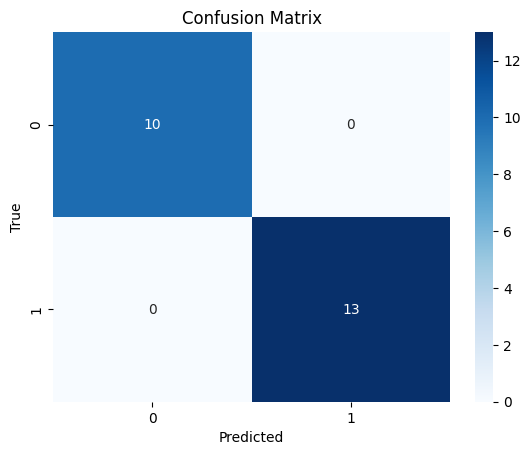


🔍 LIME Explanation for Instance 0


[('v5 > 0.73', -0.34250185516598863),
 ('i > 0.02', -0.32840886194311825),
 ('-0.36 < v1 <= 0.60', -0.13752195880696666),
 ('-0.98 < ii <= -0.95', 0.002492041675562058)]

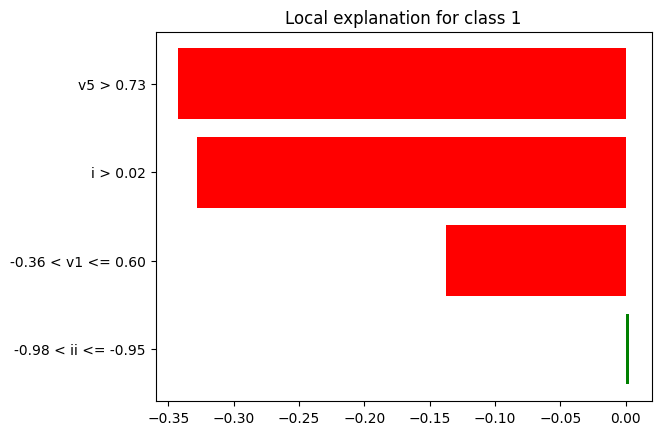


🔍 LIME Explanation for Instance 1


[('v5 > 0.73', -0.329491147512268),
 ('i > 0.02', -0.32824527608652626),
 ('-0.36 < v1 <= 0.60', -0.1431767091959247),
 ('ii > -0.95', -4.224388106886158e-05)]

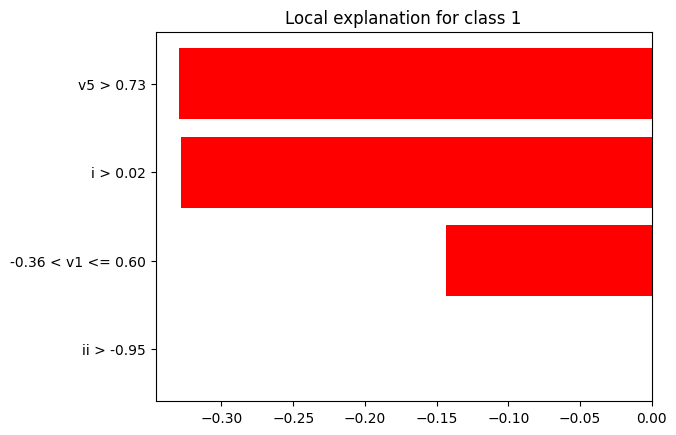


🔍 LIME Explanation for Instance 2


[('-0.22 < v5 <= -0.18', 0.2187963184511951),
 ('-0.40 < v1 <= -0.36', 0.21788657239768197),
 ('-1.00 < i <= -0.94', 0.21112060615589615),
 ('-0.98 < ii <= -0.95', 0.007583538072291782)]

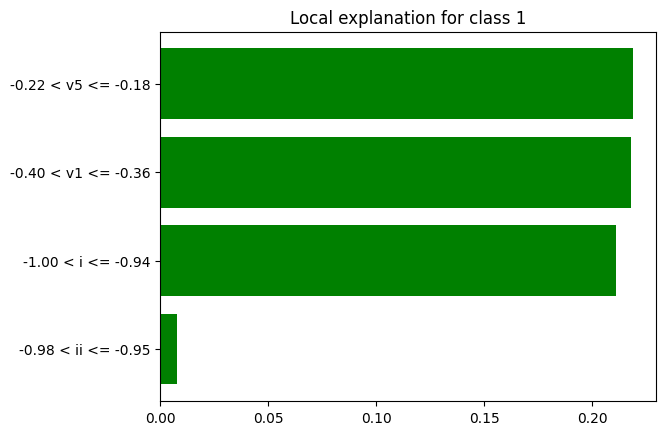

✅ Results saved as model_comparison_results.xlsx


In [ ]:
# ------------------------------------------------
# 📈 Cell 6: Evaluate and Visualize
# ------------------------------------------------
y_pred = stack_pipe.predict(X_test)
print('\n📋 Classification Report:')
print(classification_report(y_test, y_pred))
print('\nConfusion Matrix:')

# Define class_names before using it in plot_cm
class_names = [str(c) for c in sorted(y.unique())]
plot_cm(y_test, y_pred, labels=class_names)

# ------------------------------------------------
# 💡 Cell 7: LIME Explainability
# ------------------------------------------------
feature_names = X_train.columns.tolist()
class_names = [str(c) for c in sorted(y.unique())]

for i in range(min(3, X_test.shape[0])):
    instance = X_test.iloc[i].values
    exp = explain_with_lime(stack_pipe, X_train, feature_names, class_names, instance)
    print(f'\n🔍 LIME Explanation for Instance {i}')
    display(exp.as_list())
    fig = exp.as_pyplot_figure()
    plt.show()

# ------------------------------------------------
# 💾 Cell 8: Save Results Table
# ------------------------------------------------
results.to_excel('model_comparison_results.xlsx', index=False)
print('✅ Results saved as model_comparison_results.xlsx')